# Generative Adversarial Networks (GANs)

Le processus d’apprentissage repose sur un jeu minimax entre les deux réseaux :
- Le générateur tente de tromper le discriminateur en produisant des données réalistes.
- Le discriminateur cherche à détecter les faux parmi les vrais.
- L’objectif global est d’atteindre un équilibre où le générateur produit des données si convaincantes
que le discriminateur ne peut plus les différencier des vraies données (c’est-à-dire une
probabilité de 50 % pour chaque décision du discriminateur).

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, jaccard_score
from PIL import Image
import os

In [27]:
# Chemins vers les répertoires
data_dir = r"C:\Users\beriv\OneDrive\Bureau\pill"

Les résultats sont dans le dossier : "C:\Users\beriv\GAN_Output"

In [29]:
# Hyperparamètres
latent_dim = 100
img_size = 64
batch_size = 32
epochs = 500
lr = 0.0002
b1, b2 = 0.5, 0.999  # hyperparamètres de l'optimiseur adam

### Preprocessing 

Chaque catégorie comprend des données normales et des anomalies de différentes natures, telles que des rayures, des fissures, des contaminations ou des défauts structurels. 

Ce dataset est particulièrement utile pour entraîner et évaluer des modèles non supervisés de détection d’anomalies.

In [30]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error opening file {img_path}: {e}")
            raise
        if self.transform:
            img = self.transform(img)
        return img
    
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

In [31]:
dataset = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\train\good", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

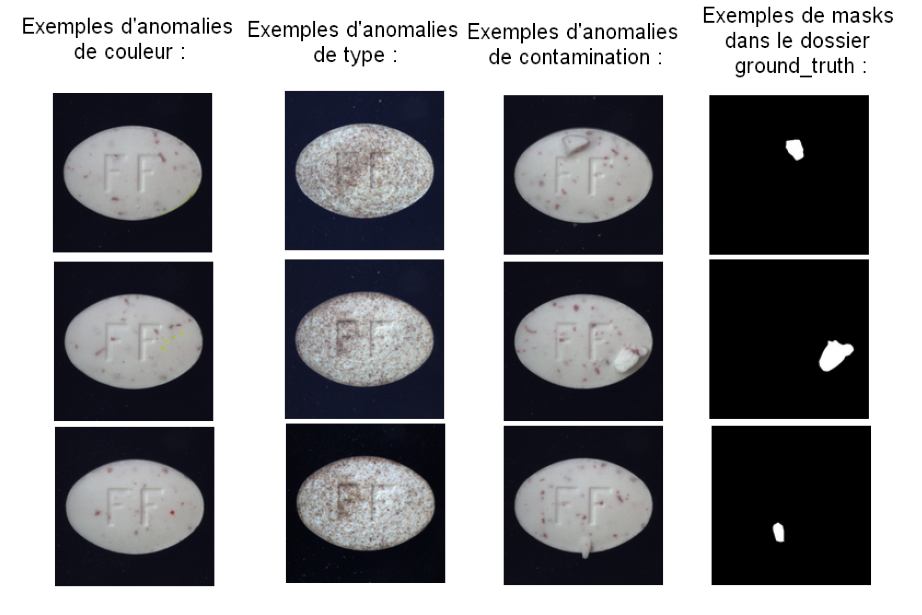

### Générateur

Son objectif est de créer des données synthétiques (par exemple, des images)
qui ressemblent le plus possible aux données réelles.

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, img_size * img_size * 3),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, img_size, img_size)
        return img

### Discriminateur

Ce réseau est un classificateur binaire. Il apprend à distinguer les données
générées par le générateur des données réelles issues du dataset d’entraînement. Son rôle est
de "critiquer" les données produites par le générateur.

Le processus d’apprentissage repose sur un jeu minimax entre les deux réseaux :
- Le générateur tente de tromper le discriminateur en produisant des données réalistes.
- Le discriminateur cherche à détecter les faux parmi les vrais.
- L’objectif global est d’atteindre un équilibre où le générateur produit des données si convaincantes
que le discriminateur ne peut plus les différencier des vraies données (c’est-à-dire une
probabilité de 50 % pour chaque décision du discriminateur).

In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * 3, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

**BCE loss (Binary Cross-Entropy Loss)** : fonction de perte utilisée dans les tâches de classification binaire

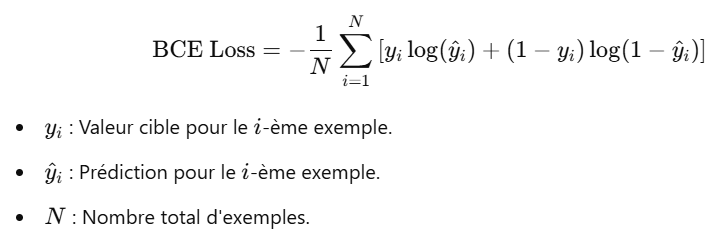

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Définition du device (GPU si disponible, sinon CPU)

# Initialisation des modèles
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimiseurs
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Fonction de perte
adversarial_loss = nn.BCELoss().to(device)

In [35]:
# Dossier oùsont stockés les sorties
output_dir = r"C:\Users\beriv\GAN_Output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

os.chdir(output_dir)
checkpoint_dir = os.path.join(output_dir, "checkpoints")
image_dir = os.path.join(output_dir, "images")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

print("Saving files to:", os.getcwd())

Saving files to: C:\Users\beriv\GAN_Output


In [46]:
import gc
gc.collect()

86836

In [36]:
# Boucle d'entrainement
start_epoch = 495

# On charge le checkpoint si disponible
if os.path.exists(os.path.join(checkpoint_dir, 'generator_checkpoint.pth')):
    generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'generator_checkpoint.pth')))
    discriminator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'discriminator_checkpoint.pth')))
    optimizer_G.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'optimizer_G_checkpoint.pth')))
    optimizer_D.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'optimizer_D_checkpoint.pth')))
    start_epoch = torch.load(os.path.join(checkpoint_dir, 'epoch_checkpoint.pth')) + 1
    print(f"Resuming training from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    for i, imgs in enumerate(dataloader):
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch + 1}/{epochs}, Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

    # Saving des images tous les 10 epochs
    if (epoch + 1) % 10 == 0:
        save_image(gen_imgs.data[:25], os.path.join(image_dir, f"epoch_{epoch + 1}.png"), nrow=5, normalize=True)

    # Saving des modèles et checkpoints tous les 20 epochs
    if (epoch + 1) % 20 == 0:
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, 'generator_checkpoint.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, 'discriminator_checkpoint.pth'))
        torch.save(optimizer_G.state_dict(), os.path.join(checkpoint_dir, 'optimizer_G_checkpoint.pth'))
        torch.save(optimizer_D.state_dict(), os.path.join(checkpoint_dir, 'optimizer_D_checkpoint.pth'))
        torch.save(epoch, os.path.join(checkpoint_dir, 'epoch_checkpoint.pth'))
        print(f"Checkpoints saved at epoch {epoch + 1}.")

print("Training complete.")

C:\Users\beriv\AppData\Local\Temp\ipykernel_4768\922645139.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.join(checkpoint_d

Resuming training from epoch 500
Training complete.


C:\Users\beriv\AppData\Local\Temp\ipykernel_4768\922645139.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer_D.load_state_dict(torch.load(os.path.join(checkpoint

In [37]:
# Répertoire pour sauvegarder les checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Sauvegarde des modèles et des optimiseurs
torch.save(generator.state_dict(), os.path.join(checkpoint_dir, "generator_final.pth"))
torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, "discriminator_final.pth"))
torch.save(optimizer_G.state_dict(), os.path.join(checkpoint_dir, "optimizer_G_final.pth"))
torch.save(optimizer_D.state_dict(), os.path.join(checkpoint_dir, "optimizer_D_final.pth"))

# Sauvegarde de l'epoch
torch.save(500, os.path.join(checkpoint_dir, "epoch_final.pth"))

print("Training and models saved successfully after 500 epochs.")

Training and models saved successfully after 500 epochs.


C:\Users\beriv\AppData\Local\Temp\ipykernel_4768\1102332178.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(r"C:\Users\beriv\GAN_Out

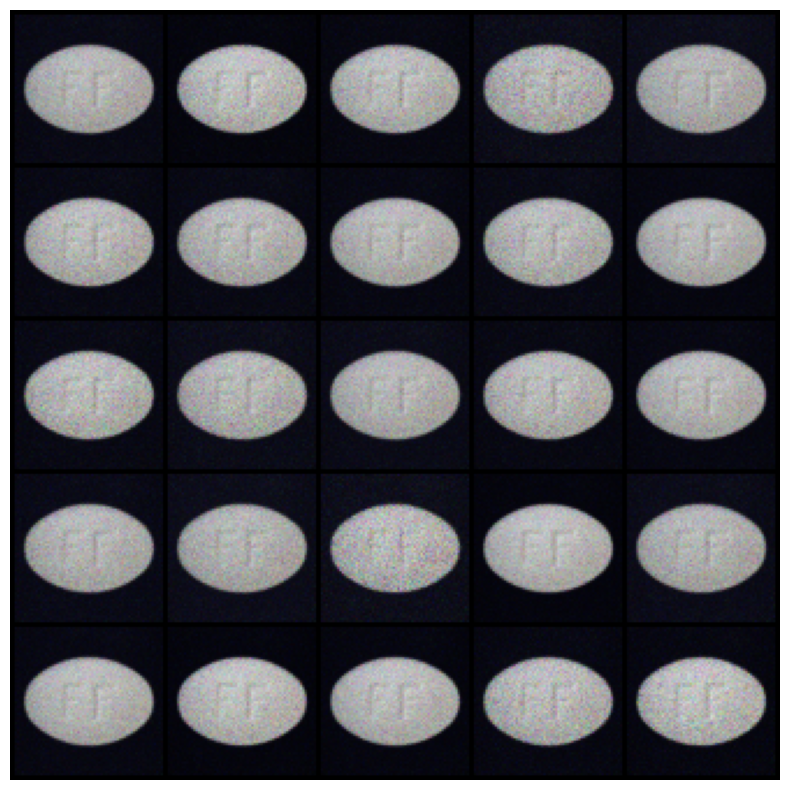

In [38]:
# Chargement du générateur sauvegardé
generator.load_state_dict(torch.load(r"C:\Users\beriv\GAN_Output\checkpoints\generator_final.pth"))
generator.eval()

# Généreration d'images aléatoires
z = torch.randn(25, latent_dim).to(device)
gen_images = generator(z)

# Dénormalisation des images pour les afficher
gen_images = (gen_images + 1) / 2  # Remettre dans la plage [0, 1]

# Visualisation les images générées
grid = torchvision.utils.make_grid(gen_images, nrow=5)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [39]:
def calculate_reconstruction_error(original, reconstructed):
    return torch.mean((original - reconstructed) ** 2, dim=[1, 2, 3])

# Chargement des données de test
test_dataset1 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\color", transform=transform)
test_dataset2 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\combined", transform=transform)
test_dataset3 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\contamination", transform=transform)
test_dataset4 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\crack", transform=transform)
test_dataset5 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\faulty_imprint", transform=transform)
test_dataset6 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\good", transform=transform)
test_dataset7 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\pill_type", transform=transform)
test_dataset8 = MVTecDataset(root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\scratch", transform=transform)

# Merge tous les datasets
test_dataset = ConcatDataset([
    test_dataset1, test_dataset2, test_dataset3, test_dataset4, 
    test_dataset5, test_dataset6, test_dataset7, test_dataset8
])

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Calcul de l'erreur de reconstruction

Erreur de reconstruction : $(\text{original}−\text{reconstructed})^2$

L'erreur de reconstruction dans un GAN (Generative Adversarial Network) est une mesure qui quantifie la différence entre les données d'entrée et les données reconstruites par le modèle générateur.

In [40]:
# Chargement les données de test
root_dir=r"C:\Users\beriv\OneDrive\Bureau\pill\test\color"
test_dataset = MVTecDataset(root_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calcul des erreurs de reconstruction
reconstruction_errors = []
generator.eval()

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        reconstructed_imgs = generator(z)
        error = calculate_reconstruction_error(imgs, reconstructed_imgs)
        reconstruction_errors.extend(error.cpu().numpy())

# Affichage des résultats
for idx, error in enumerate(reconstruction_errors):
    print(f"Image {idx + 1}, Reconstruction Error: {error:.4f}")

Image 1, Reconstruction Error: 0.0061
Image 2, Reconstruction Error: 0.0070
Image 3, Reconstruction Error: 0.0054
Image 4, Reconstruction Error: 0.0079
Image 5, Reconstruction Error: 0.0048
Image 6, Reconstruction Error: 0.0087
Image 7, Reconstruction Error: 0.0062
Image 8, Reconstruction Error: 0.0060
Image 9, Reconstruction Error: 0.0073
Image 10, Reconstruction Error: 0.0051
Image 11, Reconstruction Error: 0.0070
Image 12, Reconstruction Error: 0.0090
Image 13, Reconstruction Error: 0.0077
Image 14, Reconstruction Error: 0.0115
Image 15, Reconstruction Error: 0.0087
Image 16, Reconstruction Error: 0.0069
Image 17, Reconstruction Error: 0.0059
Image 18, Reconstruction Error: 0.0140
Image 19, Reconstruction Error: 0.0073
Image 20, Reconstruction Error: 0.0068
Image 21, Reconstruction Error: 0.0058
Image 22, Reconstruction Error: 0.0074
Image 23, Reconstruction Error: 0.0056
Image 24, Reconstruction Error: 0.0062
Image 25, Reconstruction Error: 0.0061


In [42]:
# Calcul du seuil basé sur les erreurs observées
errors_array = np.array([
    0.0114, 0.0056, 0.0056, 0.0052, 0.0071, 0.0068, 0.0107, 0.0049, 0.0072, 0.0077,
    0.0055, 0.0059, 0.0048, 0.0078, 0.0056, 0.0061, 0.0066, 0.0065, 0.0074, 0.0084,
    0.0066, 0.0054, 0.0065, 0.0058, 0.0069
])

# Définition d'un seuil basé sur le 95e percentile
new_threshold = np.percentile(errors_array, 95)
print(f"New threshold for anomalies: {new_threshold:.4f}")

New threshold for anomalies: 0.0102


In [43]:
# Fonction pour dénormaliser une image
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # Annule la normalisation entre [-1, 1] pour revenir à [0, 1]

def visualize_anomalies(originals, reconstructions, errors, threshold):
    for idx, (original, reconstructed, error) in enumerate(zip(originals, reconstructions, errors)):
        if error > threshold:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(denormalize(original).permute(1, 2, 0).cpu().numpy())
            plt.title(f"Original Image {idx + 1}")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(denormalize(reconstructed).permute(1, 2, 0).cpu().numpy())
            plt.title(f"Reconstructed Image {idx + 1}\nError: {error:.4f}")
            plt.axis("off")
            plt.show()

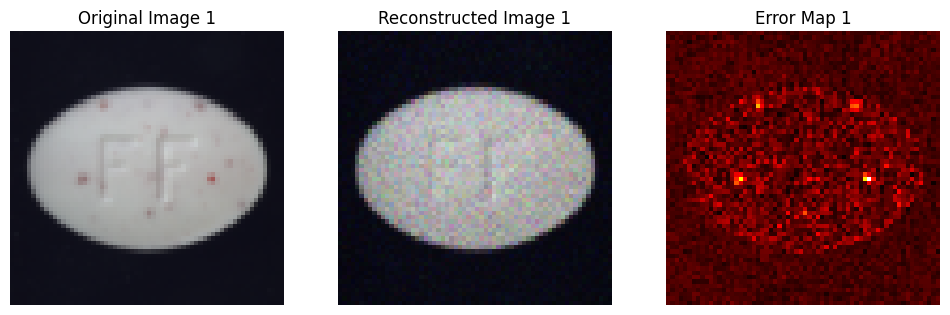

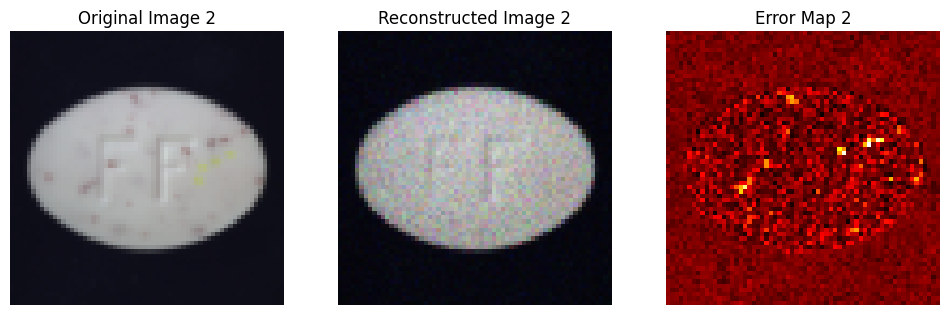

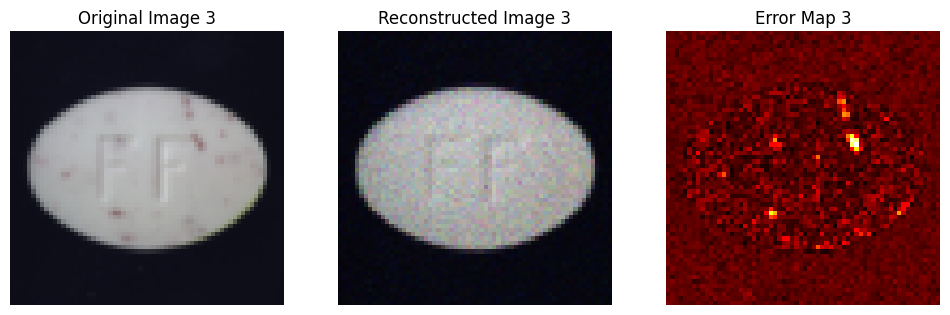

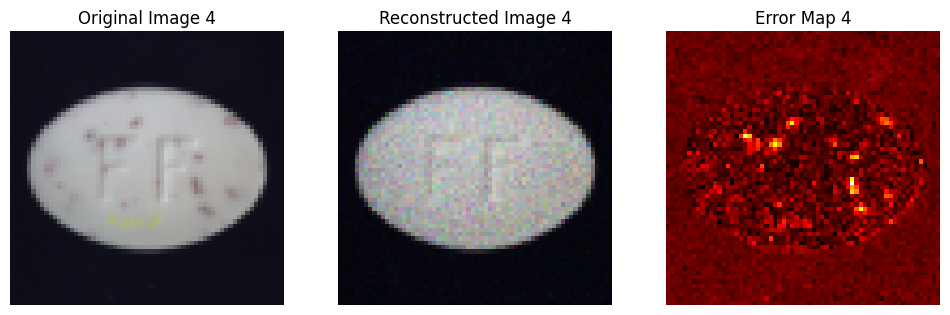

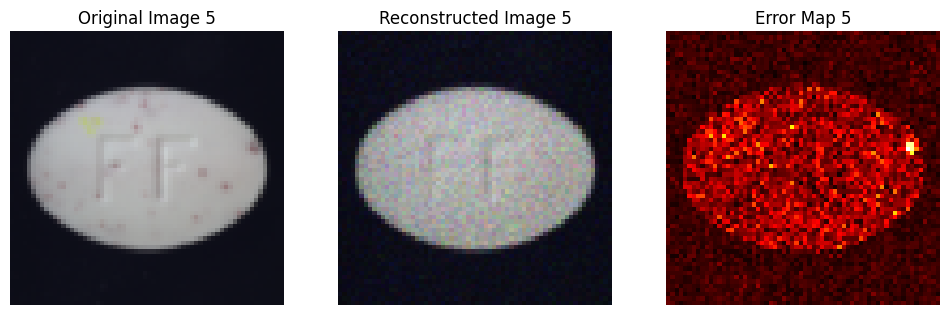

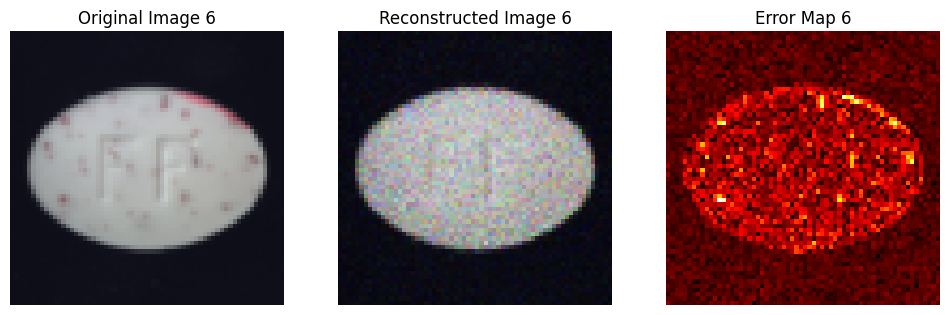

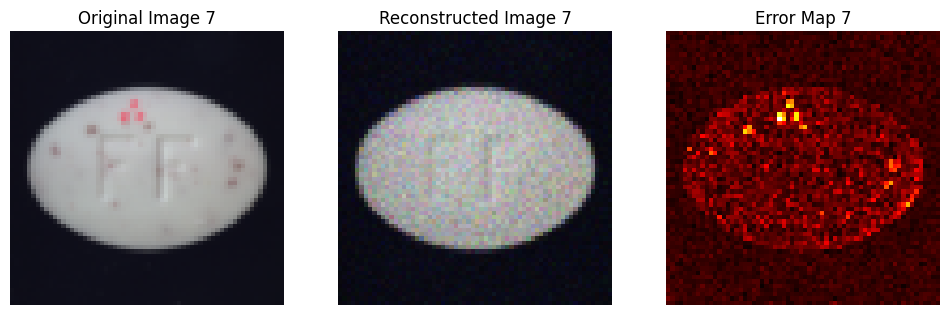

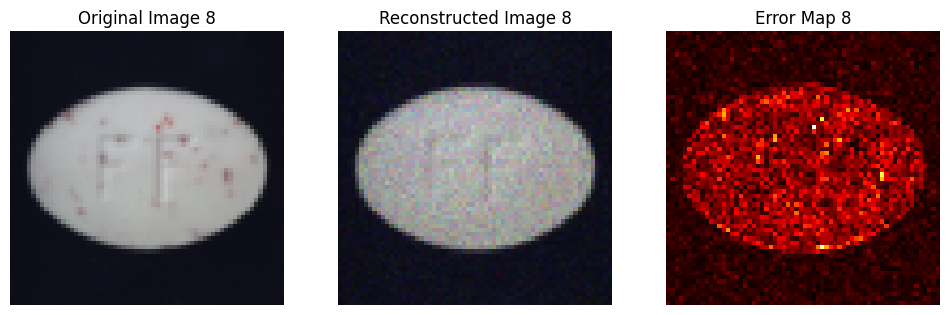

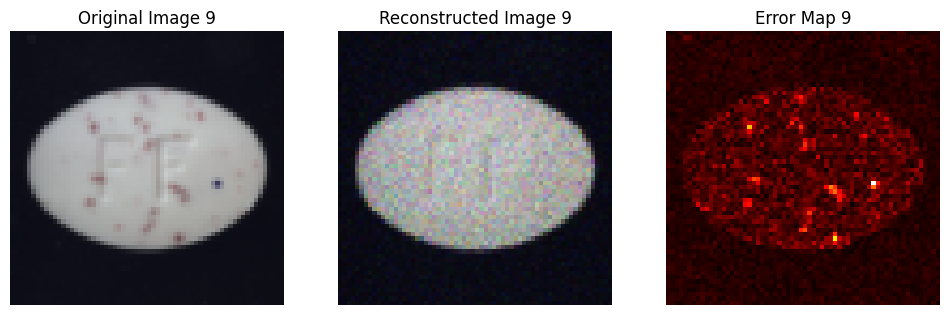

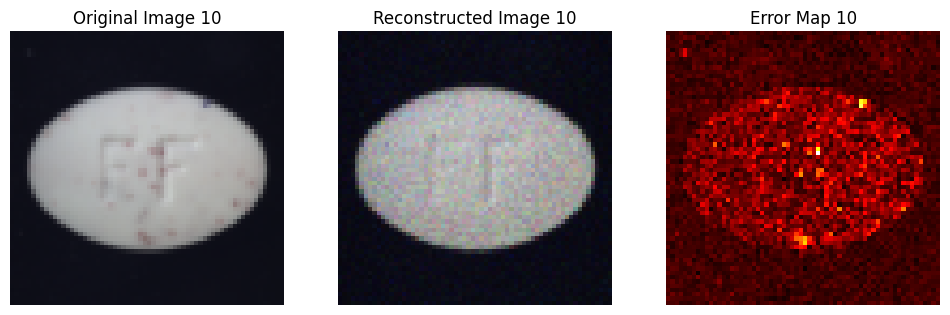

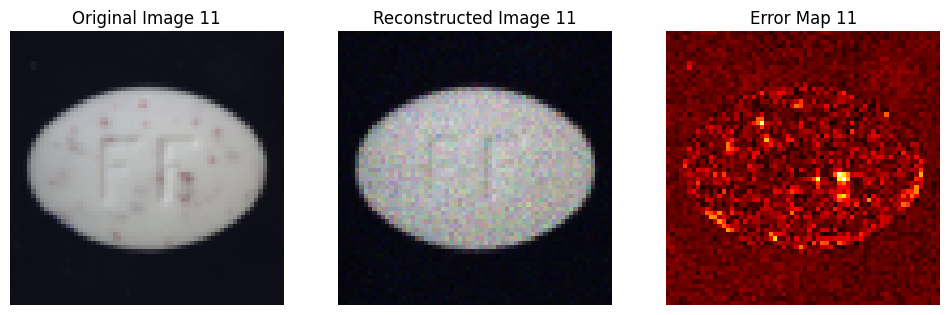

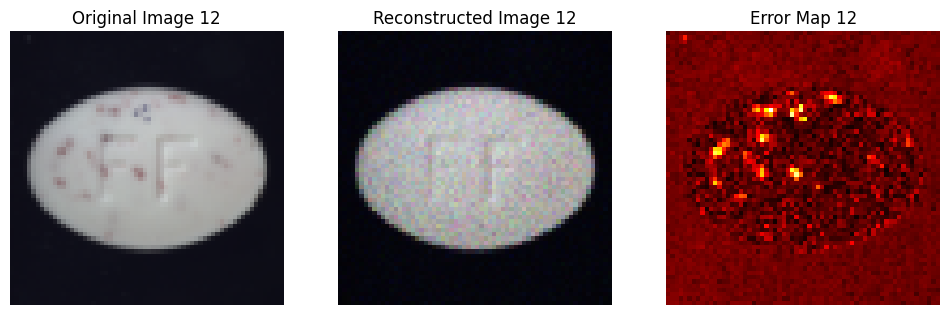

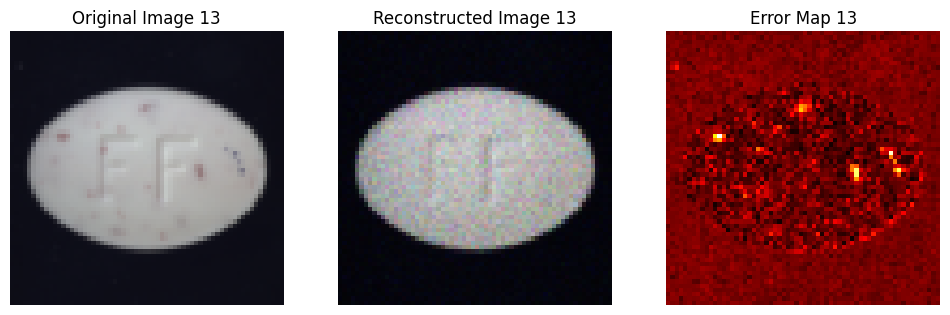

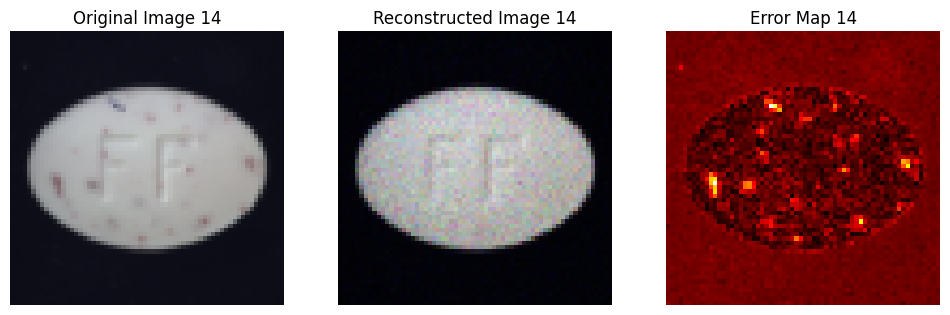

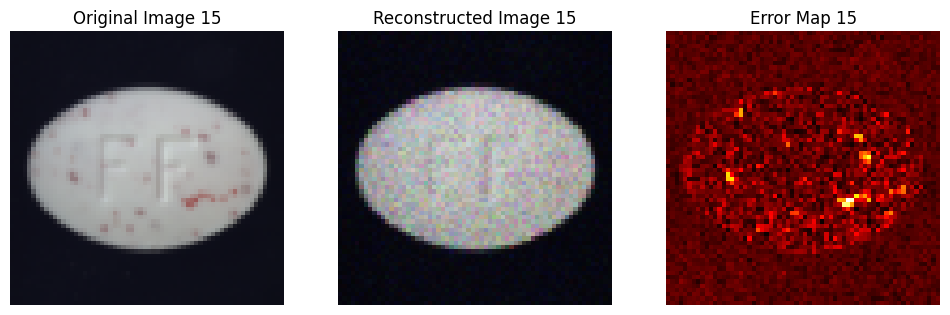

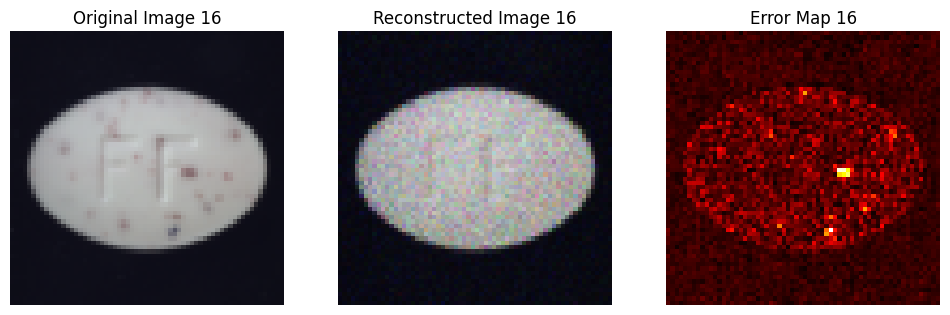

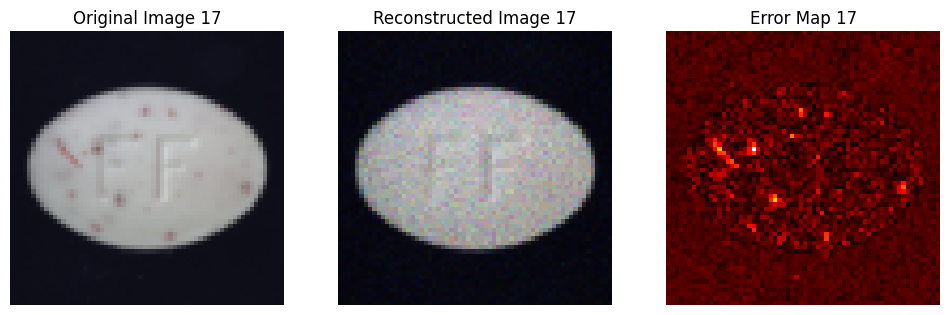

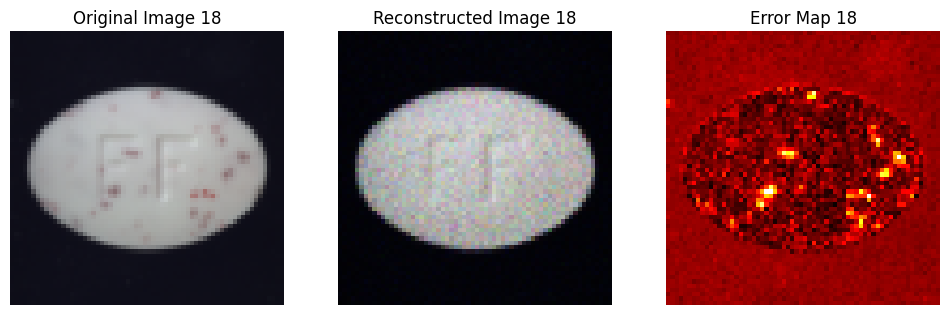

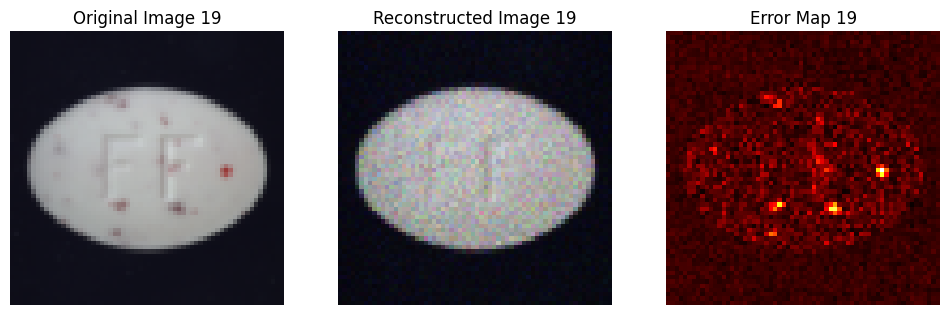

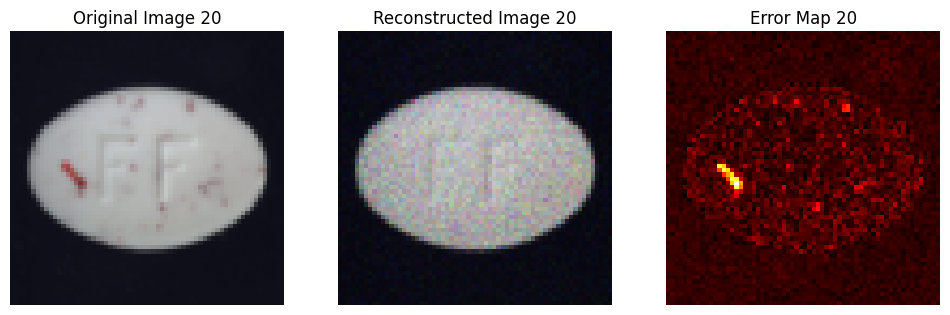

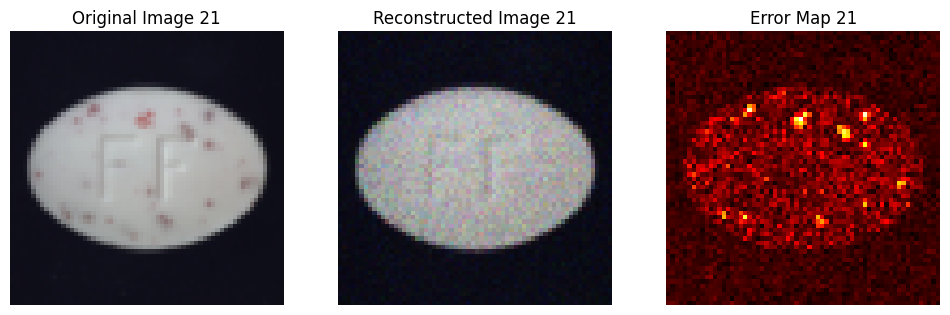

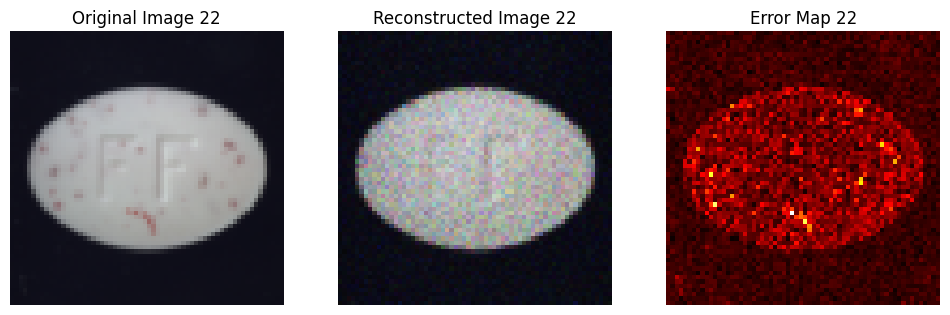

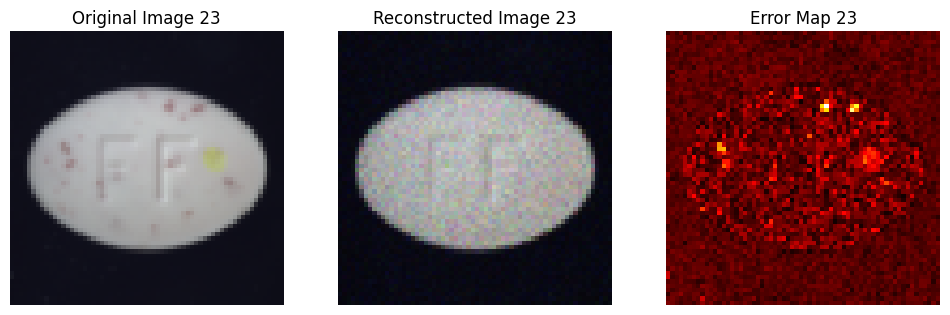

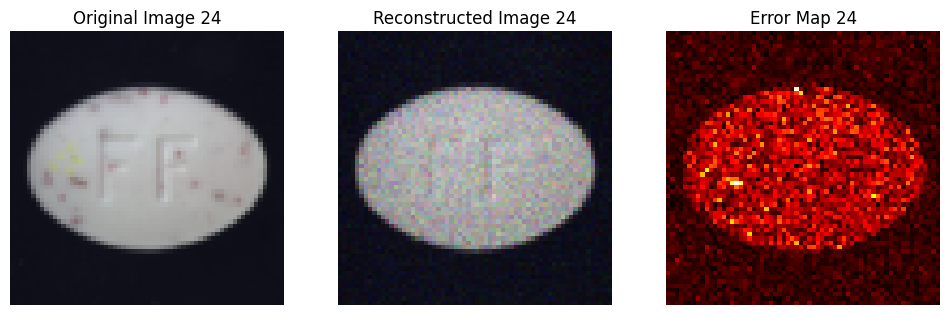

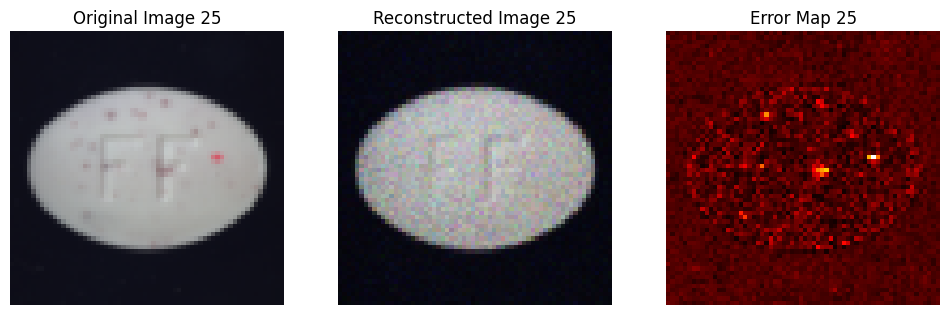

In [45]:
def visualize_differences(original, reconstructed, error, idx):
    plt.figure(figsize=(12, 4))

    # Image originale
    plt.subplot(1, 3, 1)
    plt.imshow(denormalize(original).permute(1, 2, 0).cpu().numpy())
    plt.title(f"Original Image {idx + 1}")
    plt.axis("off")

    # Image reconstruite
    plt.subplot(1, 3, 2)
    plt.imshow(denormalize(reconstructed).permute(1, 2, 0).cpu().numpy())
    plt.title(f"Reconstructed Image {idx + 1}")
    plt.axis("off")

    # Différences absolues
    diff = torch.abs(original - reconstructed).sum(dim=0).cpu().numpy()
    plt.subplot(1, 3, 3)
    plt.imshow(diff, cmap="hot")
    plt.title(f"Error Map {idx + 1}")
    plt.axis("off")

    plt.show()

# Exemple d'utilisation
for idx, (original, reconstructed, error) in enumerate(zip(imgs, reconstructed_imgs, reconstruction_errors)):
    visualize_differences(original, reconstructed, error, idx)


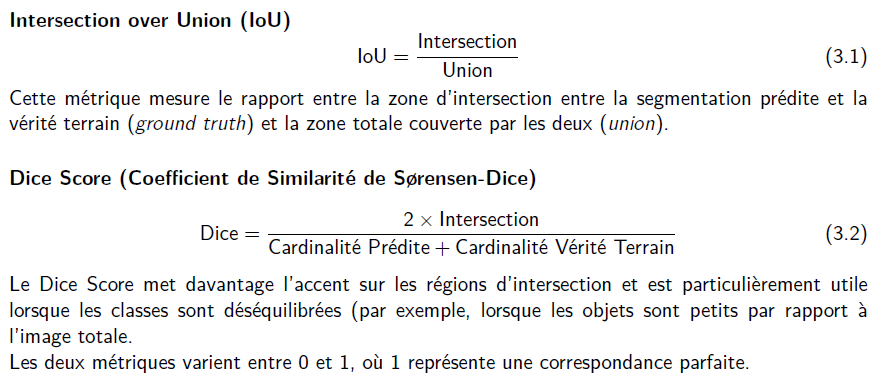

In [63]:
# Fonction pour charger le masque binaire
def load_mask(mask_path, target_size=(64, 64)):
    mask = Image.open(mask_path).convert("L")  # Convertir en niveaux de gris
    mask = mask.resize(target_size)  # Redimensionner si nécessaire
    mask = np.array(mask) > 0  # Convertir en binaire (True pour les pixels blancs)
    return torch.tensor(mask, dtype=torch.float32)

# Fonction pour calculer l'IoU et le Dice Score
def calculate_metrics(predicted_mask, ground_truth_mask):
    # Aplatir les masques pour la comparaison
    predicted_mask_flat = predicted_mask.view(-1).cpu().numpy()
    ground_truth_mask_flat = ground_truth_mask.view(-1).cpu().numpy()
    
    # IoU (Intersection over Union)
    iou = jaccard_score(ground_truth_mask_flat, predicted_mask_flat)
    
    # Dice Score
    dice = f1_score(ground_truth_mask_flat, predicted_mask_flat)
    
    return iou, dice

# Dossier contenant les masques
ground_truth_dir = r"C:\Users\beriv\OneDrive\Bureau\pill\ground_truth\color"  # Remplacer par le chemin correct
mask_files = sorted(os.listdir(ground_truth_dir))

# Exemple d'utilisation pour un batch d'images
results = []
for i, (original, reconstructed) in enumerate(zip(imgs, reconstructed_imgs)):
    # Charger le masque correspondant
    mask_path = os.path.join(ground_truth_dir, mask_files[i])
    ground_truth_mask = load_mask(mask_path, target_size=(64, 64))
    
    # Générer une carte d'erreur (différence absolue)
    error_map = torch.abs(original - reconstructed).sum(dim=0) > 0.1  # Seuillage de la différence
    
    # Calculer les métriques
    iou, dice = calculate_metrics(error_map, ground_truth_mask)
    results.append((iou, dice))
    
    print(f"Image {i + 1}: IoU = {iou:.4f}, Dice = {dice:.4f}")

# Résumé des métriques
average_iou = np.mean([r[0] for r in results])
average_dice = np.mean([r[1] for r in results])
#print(f"Average IoU: {average_iou:.4f}, Average Dice Score: {average_dice:.4f}")


Image 1: IoU = 0.0025, Dice = 0.0049
Image 2: IoU = 0.0112, Dice = 0.0222
Image 3: IoU = 0.0233, Dice = 0.0455
Image 4: IoU = 0.0130, Dice = 0.0256
Image 5: IoU = 0.0074, Dice = 0.0146
Image 6: IoU = 0.0143, Dice = 0.0281
Image 7: IoU = 0.0080, Dice = 0.0158
Image 8: IoU = 0.0071, Dice = 0.0141
Image 9: IoU = 0.0041, Dice = 0.0082
Image 10: IoU = 0.0022, Dice = 0.0044
Image 11: IoU = 0.0072, Dice = 0.0143
Image 12: IoU = 0.0042, Dice = 0.0084
Image 13: IoU = 0.0061, Dice = 0.0122
Image 14: IoU = 0.0036, Dice = 0.0071
Image 15: IoU = 0.0109, Dice = 0.0215
Image 16: IoU = 0.0056, Dice = 0.0112
Image 17: IoU = 0.0049, Dice = 0.0098
Image 18: IoU = 0.0062, Dice = 0.0124
Image 19: IoU = 0.0044, Dice = 0.0087
Image 20: IoU = 0.0084, Dice = 0.0167
Image 21: IoU = 0.0049, Dice = 0.0098
Image 22: IoU = 0.0081, Dice = 0.0161
Image 23: IoU = 0.0112, Dice = 0.0222
Image 24: IoU = 0.0115, Dice = 0.0227
Image 25: IoU = 0.0036, Dice = 0.0071
Average IoU: 0.0077, Average Dice Score: 0.0153


In [67]:
# Répertoire contenant les masques
ground_truth_dir = r"C:\Users\beriv\OneDrive\Bureau\pill\ground_truth\color"  # Remplacer par le chemin correct

# Charger les masques en respectant l'ordre des fichiers
mask_files = sorted(os.listdir(ground_truth_dir))  # Trier les masques par ordre alphabétique
image_files = r"C:\Users\beriv\OneDrive\Bureau\pill\test\color"  # Liste des fichiers d'images testée (assurez-vous qu'elle correspond au dataset)

# Boucle sur les images et leurs masques
for i, (original, reconstructed) in enumerate(zip(imgs, reconstructed_imgs)):
    mask_path = os.path.join(ground_truth_dir, mask_files[i])  # Obtenir le masque correspondant
    ground_truth_mask = load_mask(mask_path, target_size=(64, 64))  # Charger le masque

    # Calculer une carte d'erreur (différence absolue)
    error_map = torch.abs(original - reconstructed).sum(dim=0) > 0.1  # Seuillage de la différence
    
    # Calculer les métriques (IoU et Dice)
    iou, dice = calculate_metrics(error_map, ground_truth_mask)
    print(f"Image {i + 1}: IoU = {iou:.4f}, Dice = {dice:.4f}")



Image 1: IoU = 0.0025, Dice = 0.0049
Image 2: IoU = 0.0112, Dice = 0.0222
Image 3: IoU = 0.0233, Dice = 0.0455
Image 4: IoU = 0.0130, Dice = 0.0256
Image 5: IoU = 0.0074, Dice = 0.0146
Image 6: IoU = 0.0143, Dice = 0.0281
Image 7: IoU = 0.0080, Dice = 0.0158
Image 8: IoU = 0.0071, Dice = 0.0141
Image 9: IoU = 0.0041, Dice = 0.0082
Image 10: IoU = 0.0022, Dice = 0.0044
Image 11: IoU = 0.0072, Dice = 0.0143
Image 12: IoU = 0.0042, Dice = 0.0084
Image 13: IoU = 0.0061, Dice = 0.0122
Image 14: IoU = 0.0036, Dice = 0.0071
Image 15: IoU = 0.0109, Dice = 0.0215
Image 16: IoU = 0.0056, Dice = 0.0112
Image 17: IoU = 0.0049, Dice = 0.0098
Image 18: IoU = 0.0062, Dice = 0.0124
Image 19: IoU = 0.0044, Dice = 0.0087
Image 20: IoU = 0.0084, Dice = 0.0167
Image 21: IoU = 0.0049, Dice = 0.0098
Image 22: IoU = 0.0081, Dice = 0.0161
Image 23: IoU = 0.0112, Dice = 0.0222
Image 24: IoU = 0.0115, Dice = 0.0227
Image 25: IoU = 0.0036, Dice = 0.0071


## Résultats

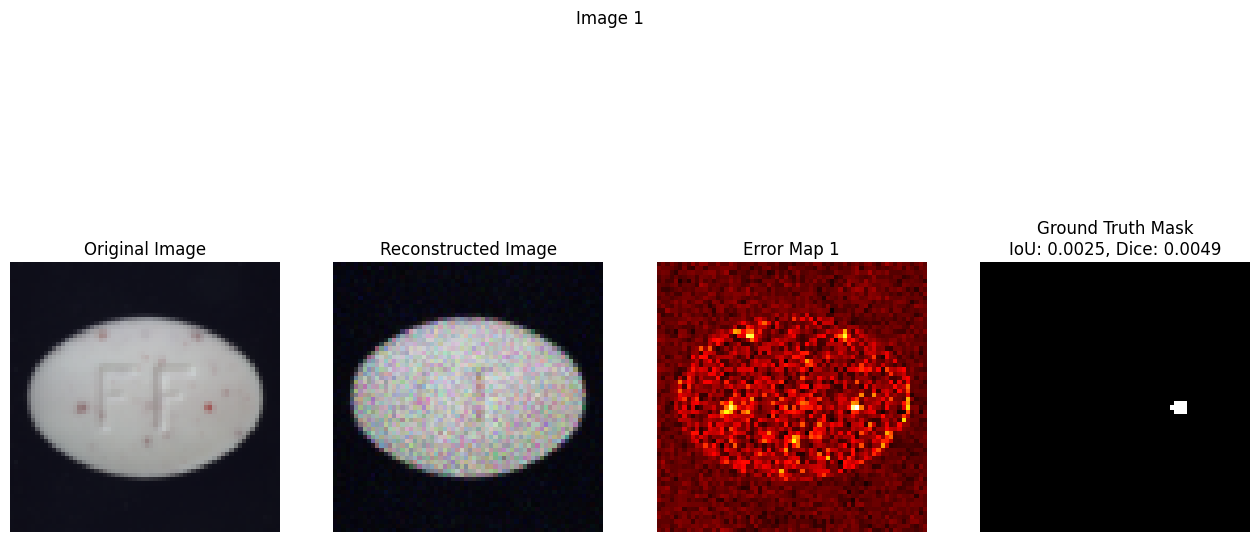

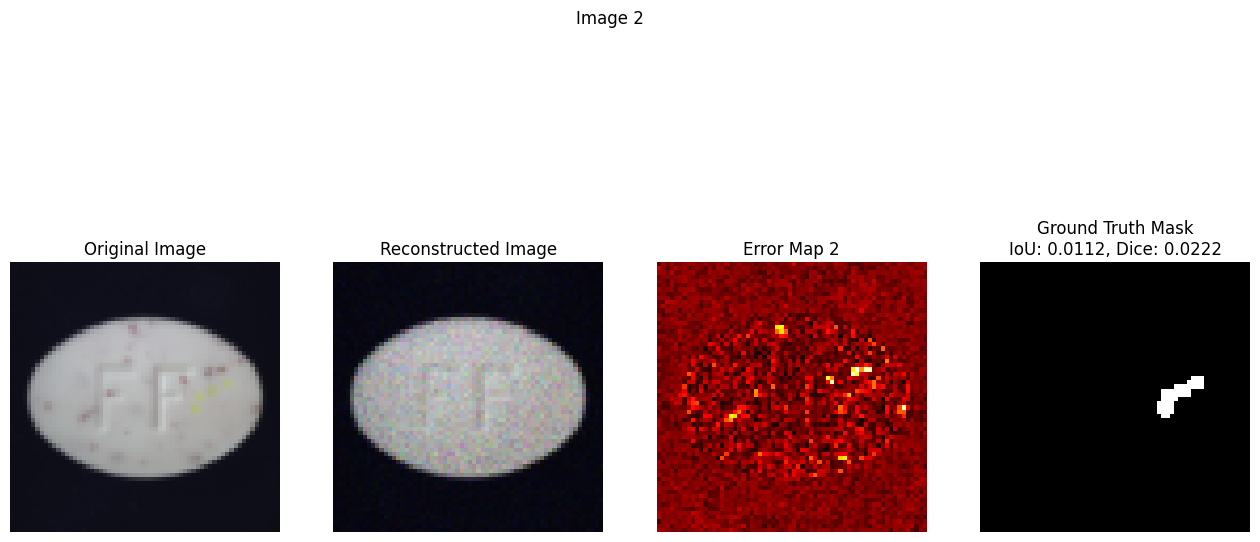

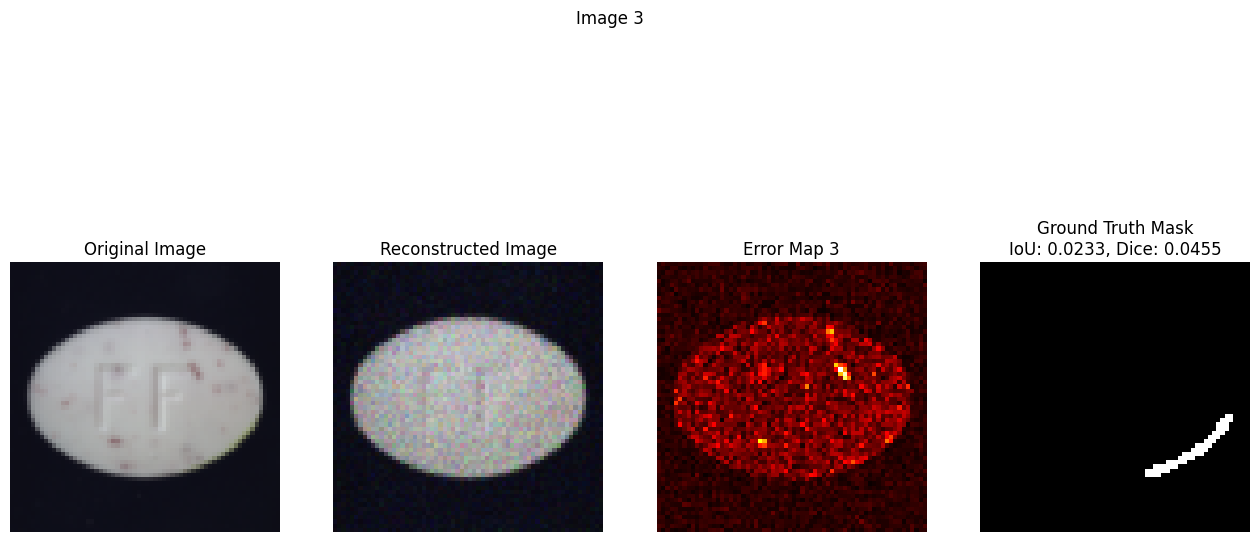

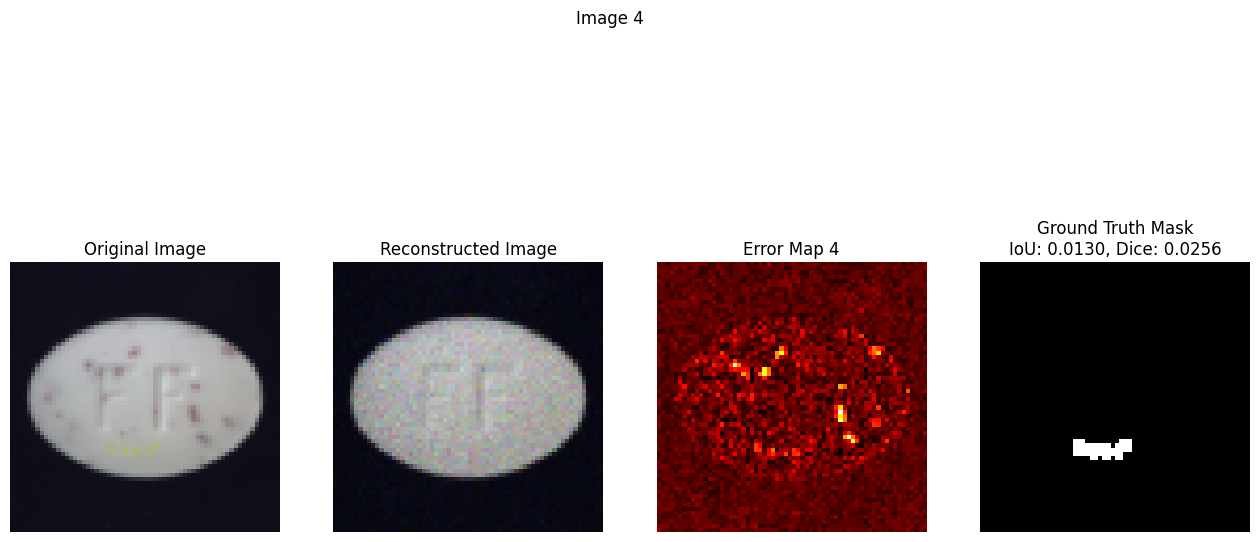

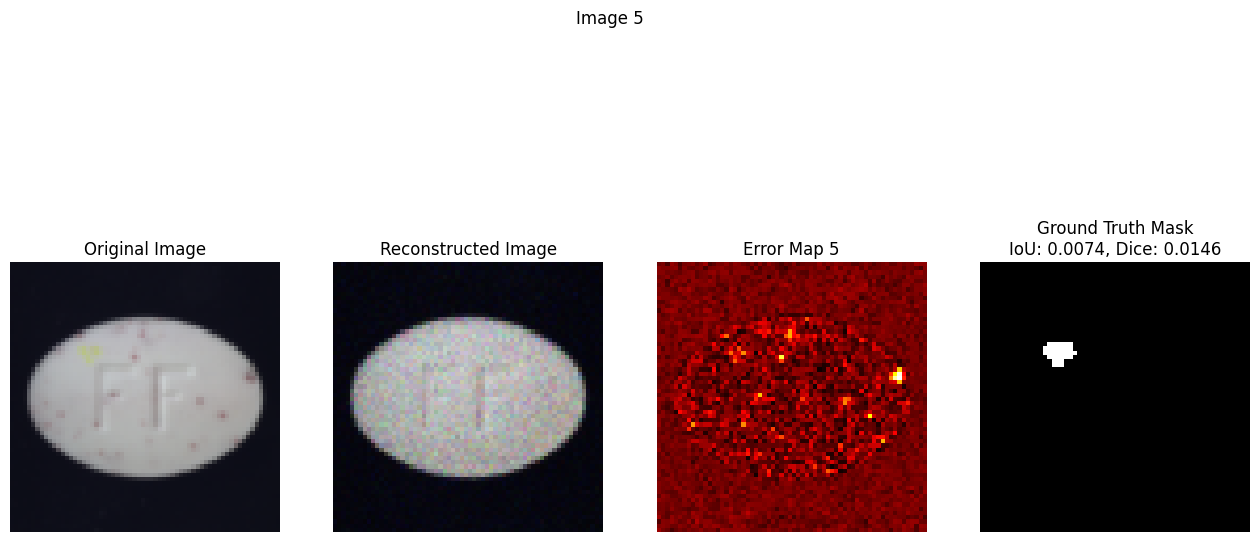

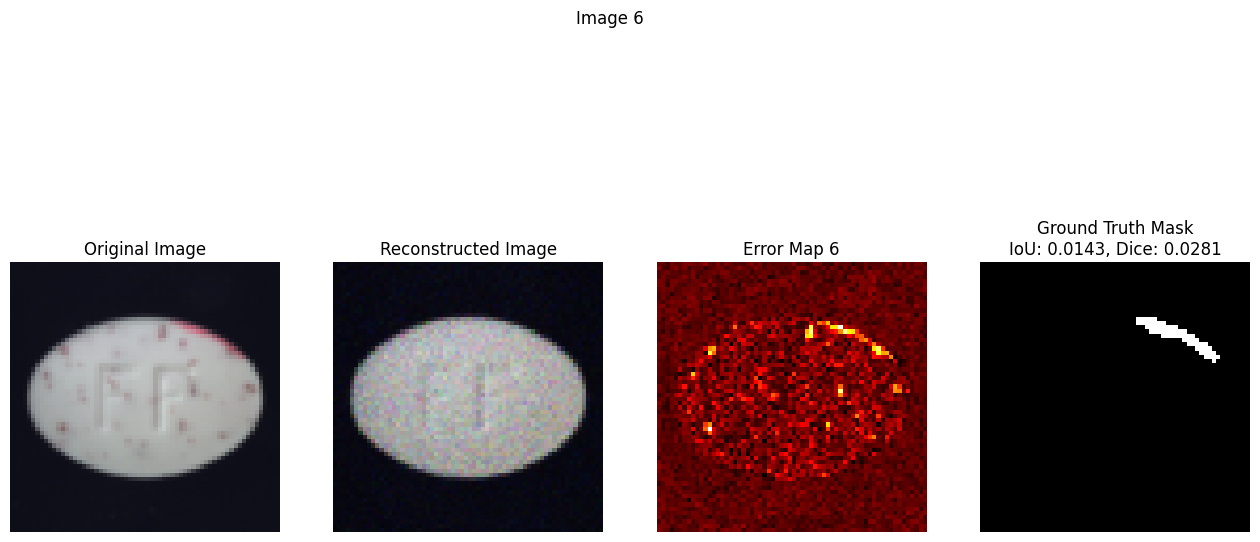

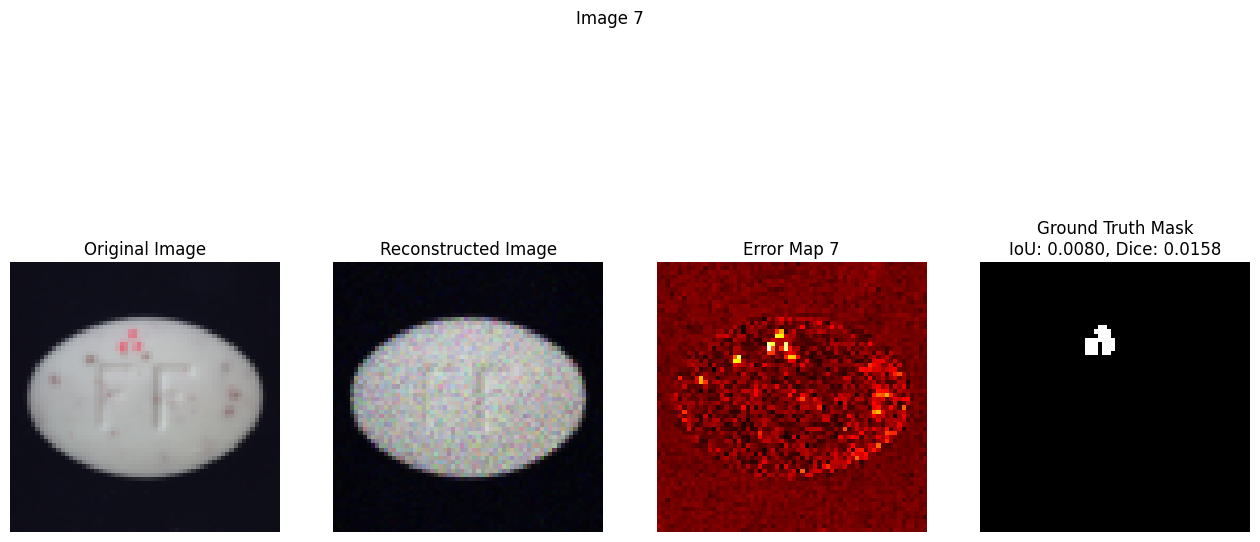

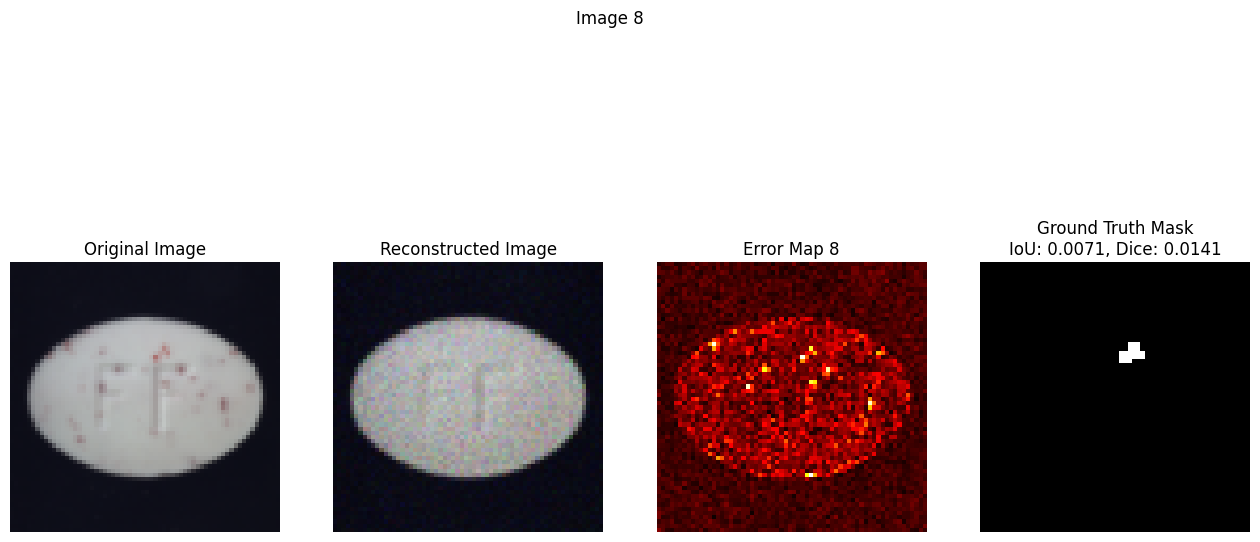

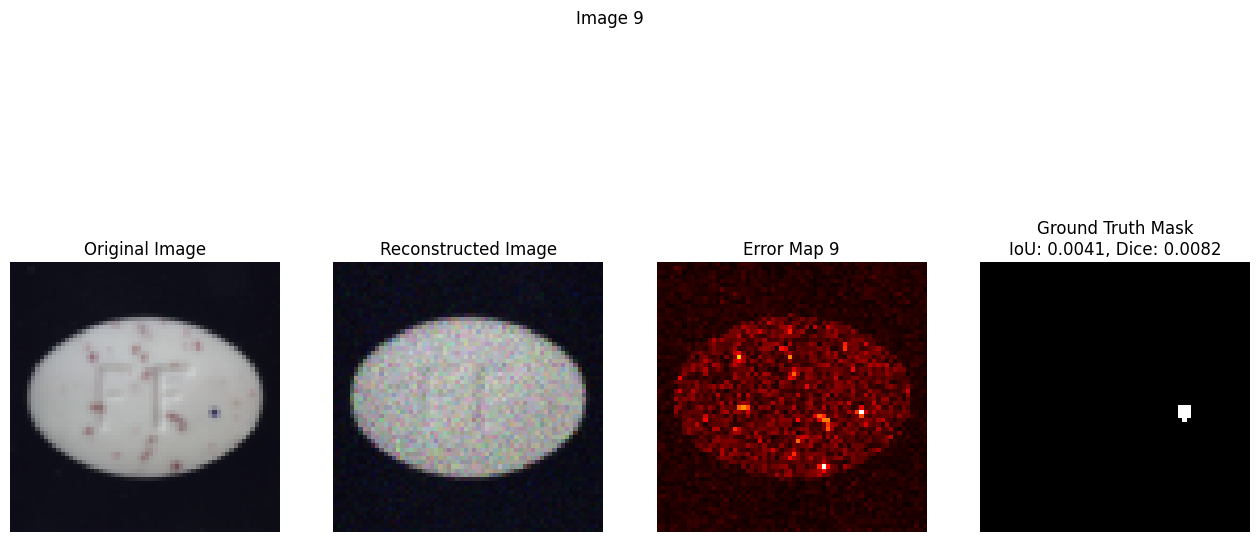

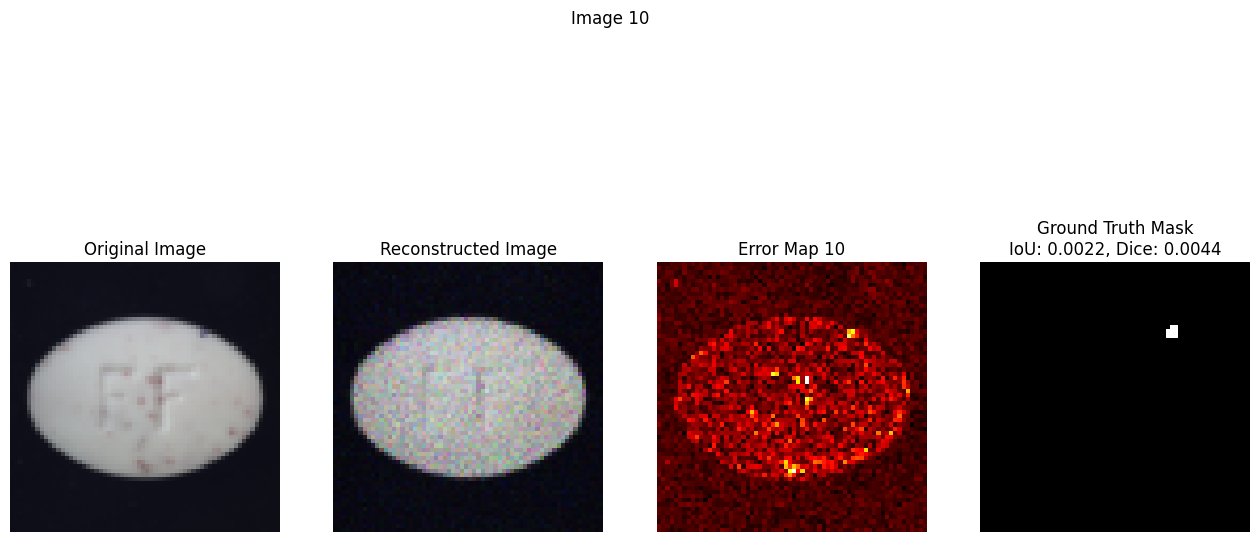

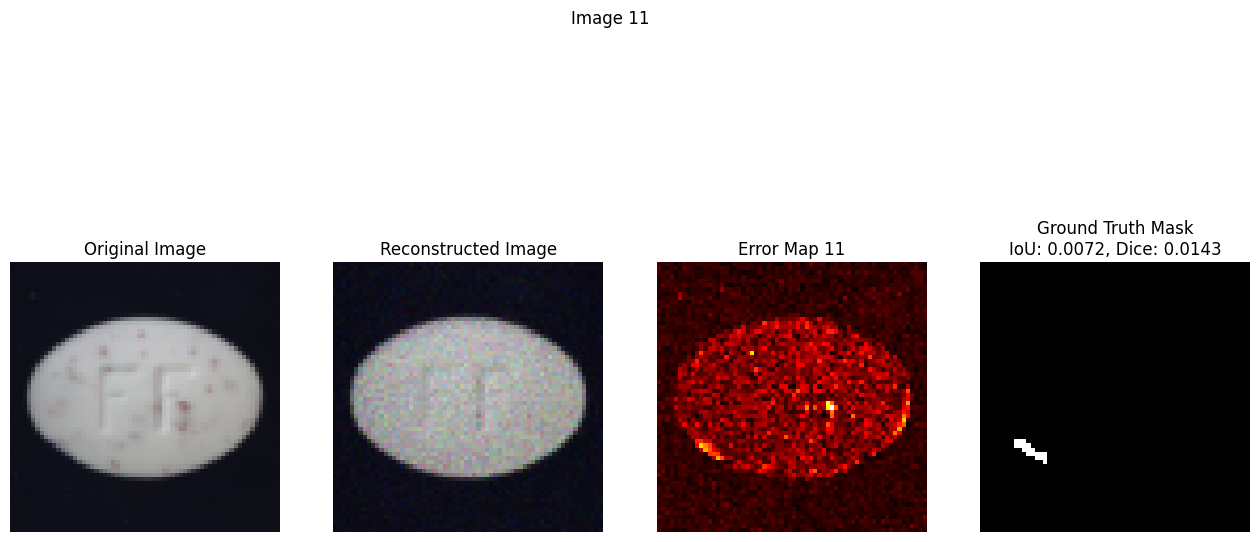

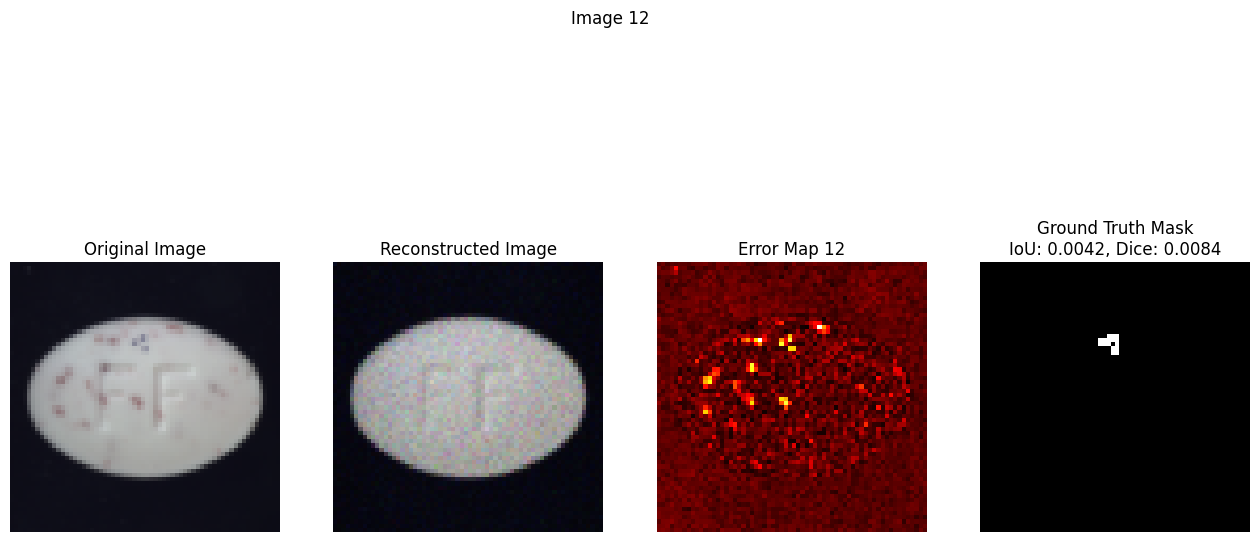

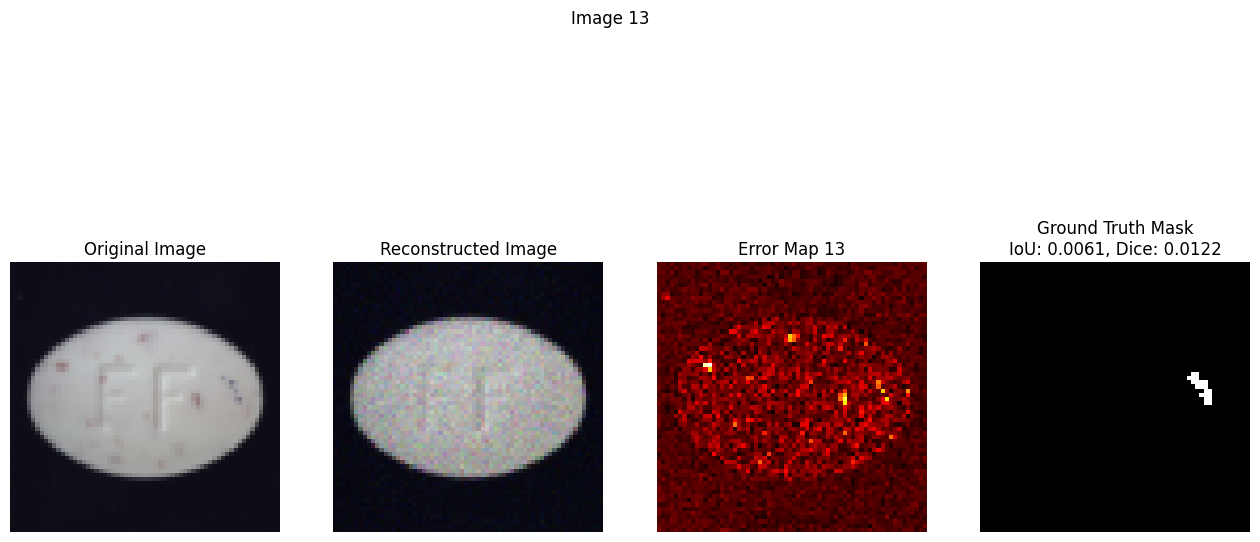

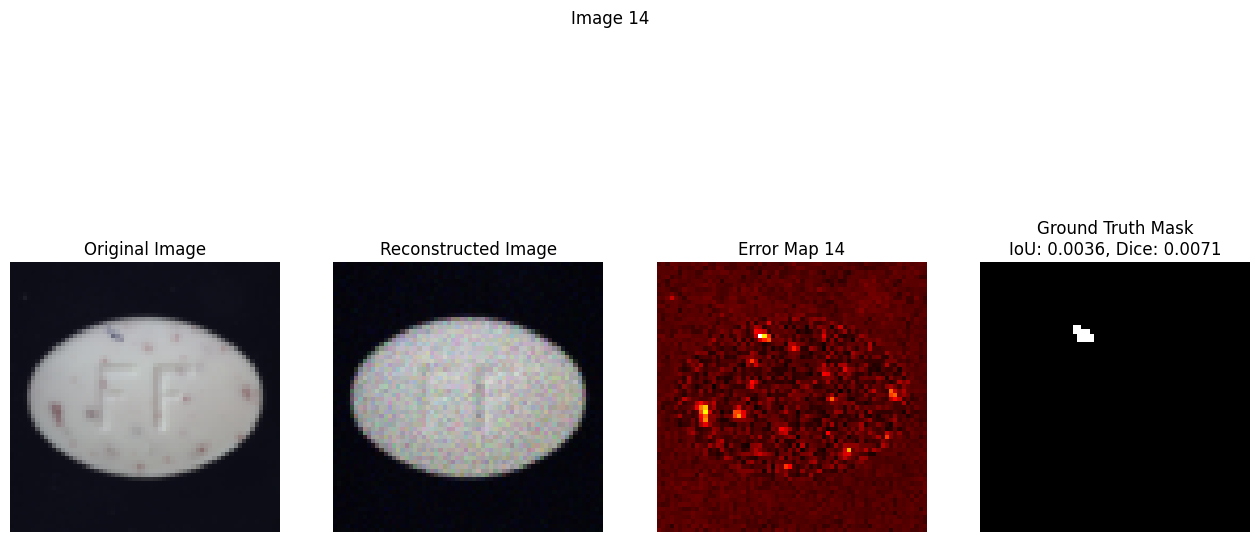

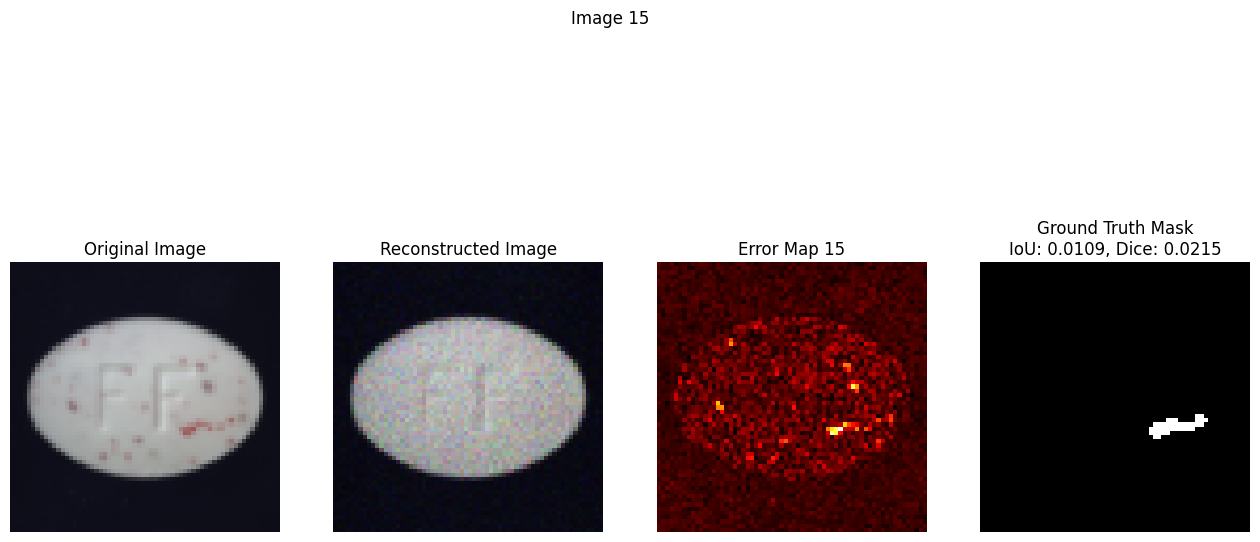

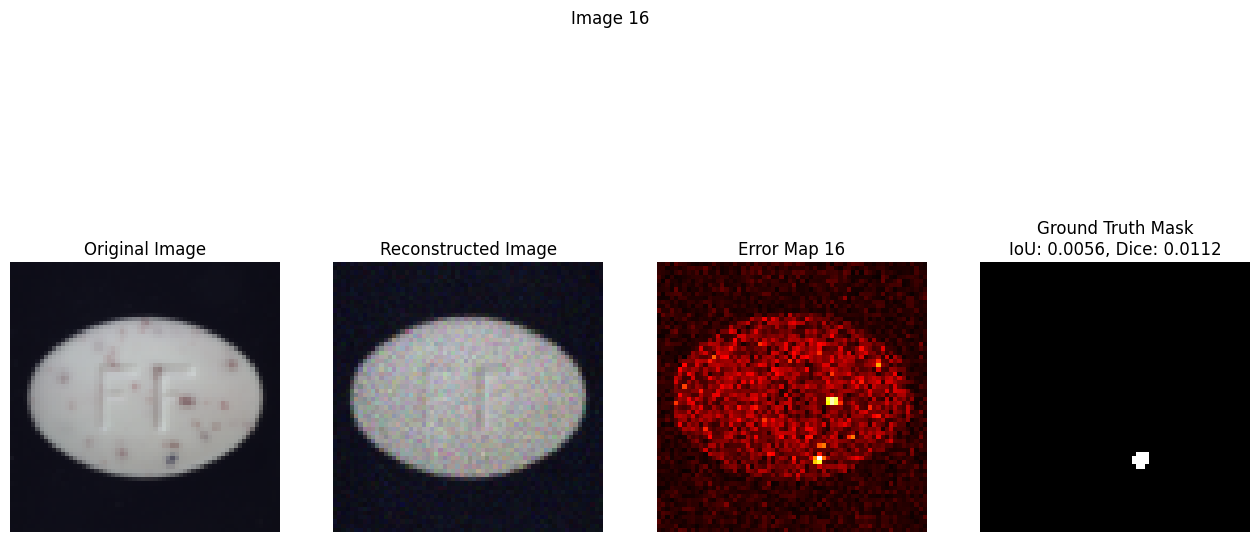

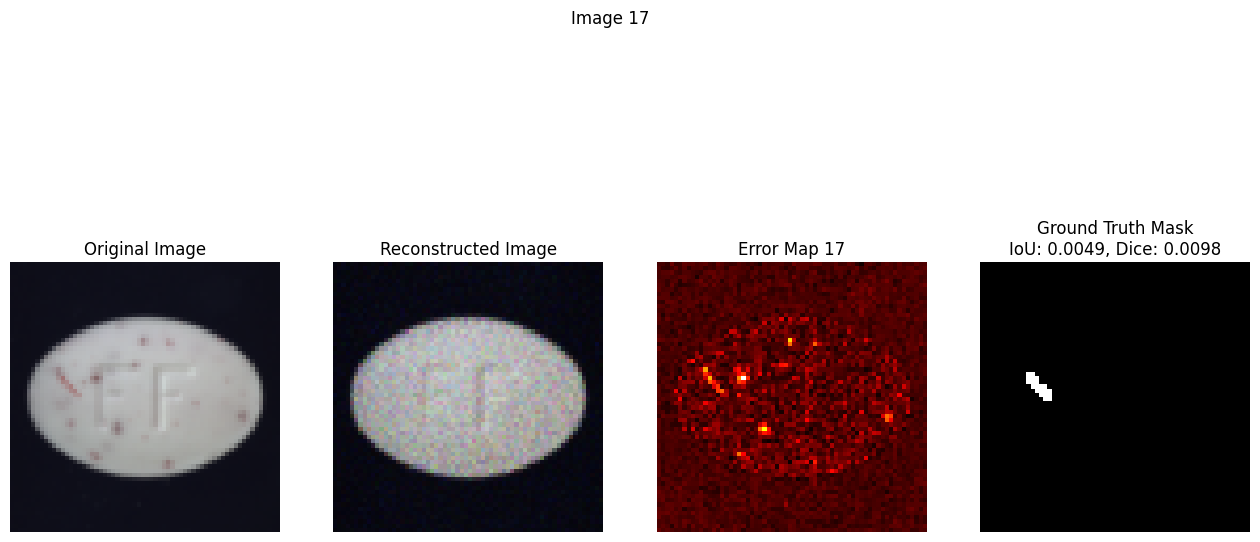

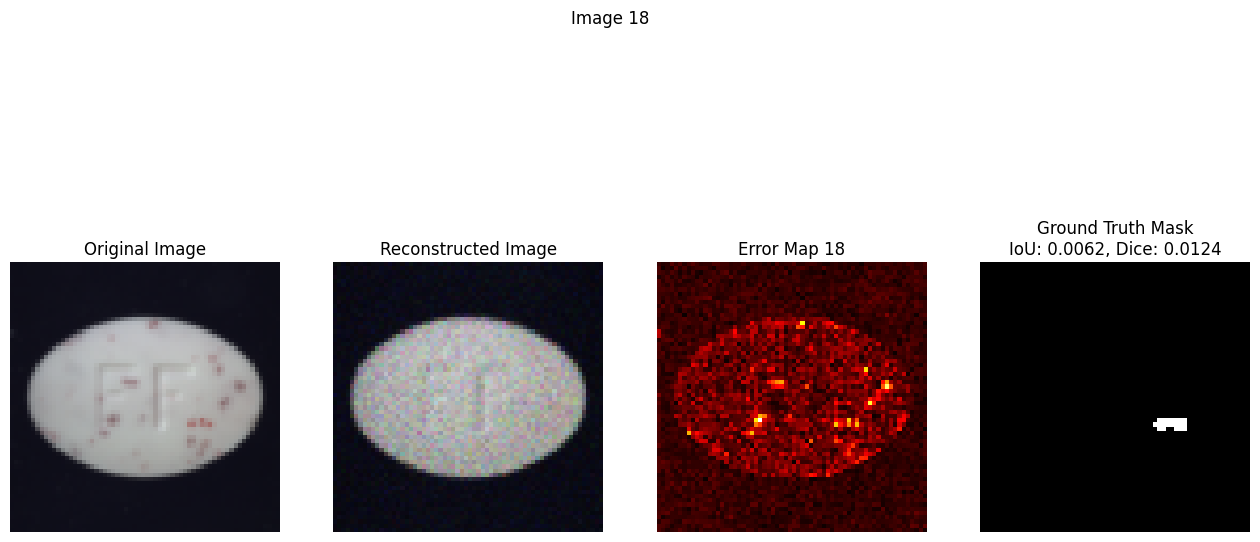

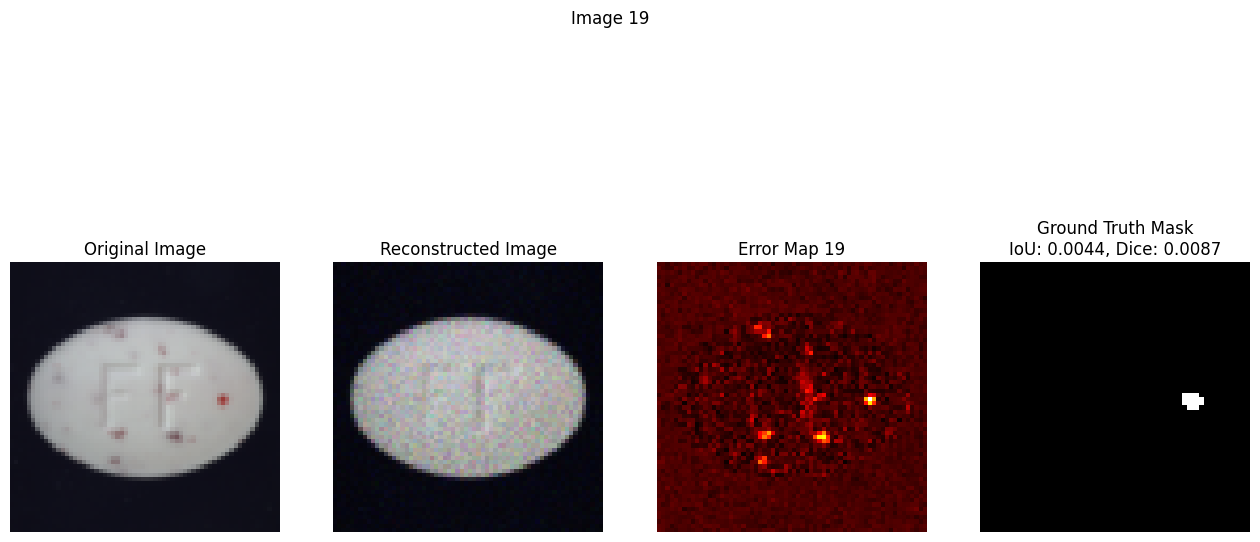

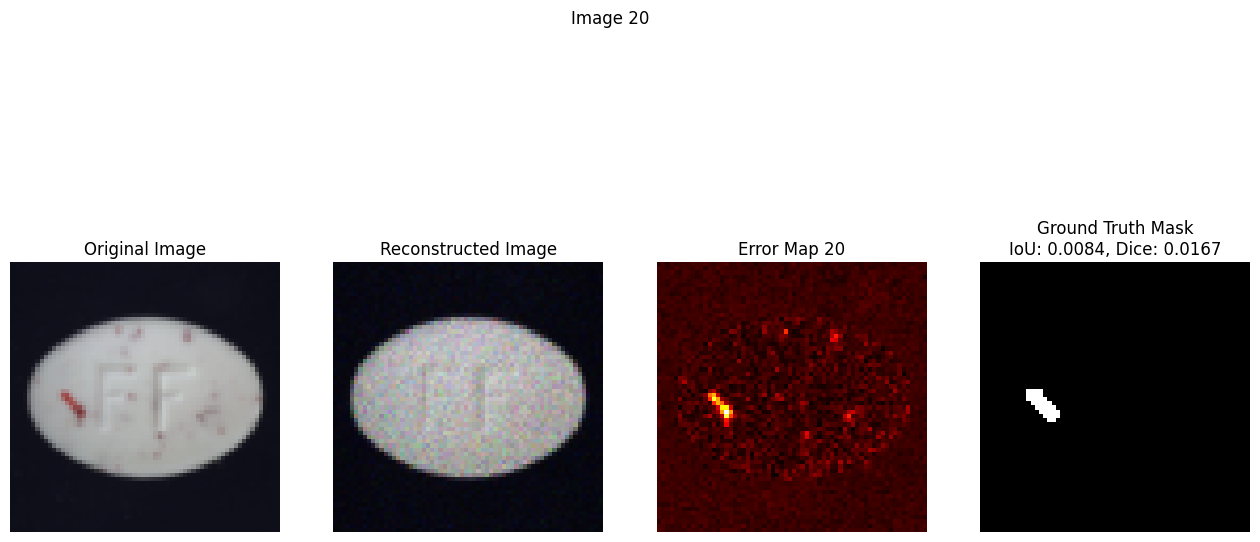

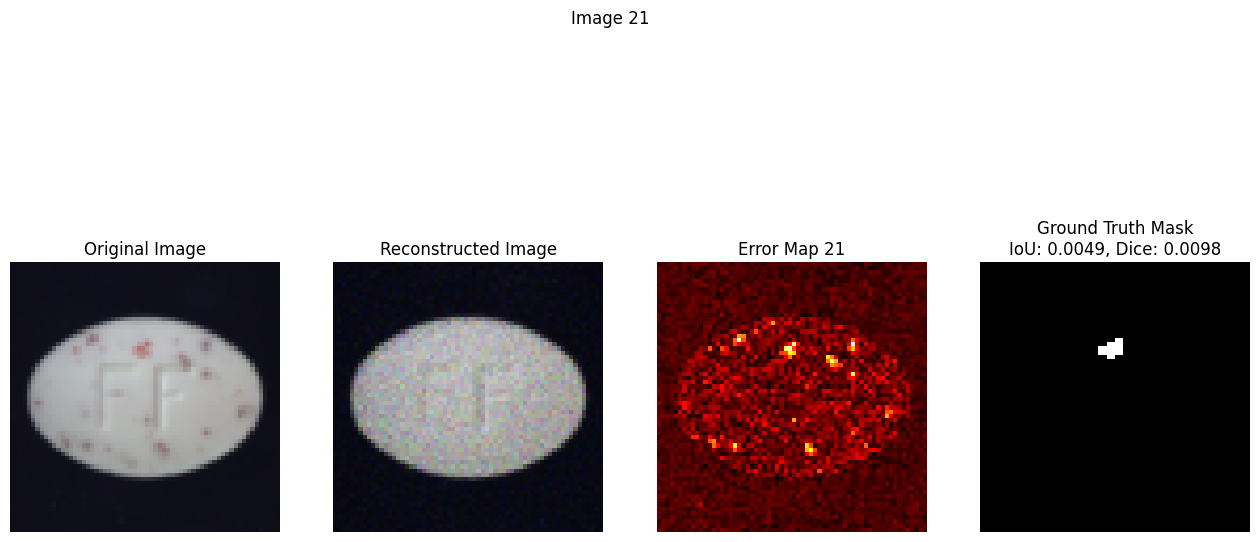

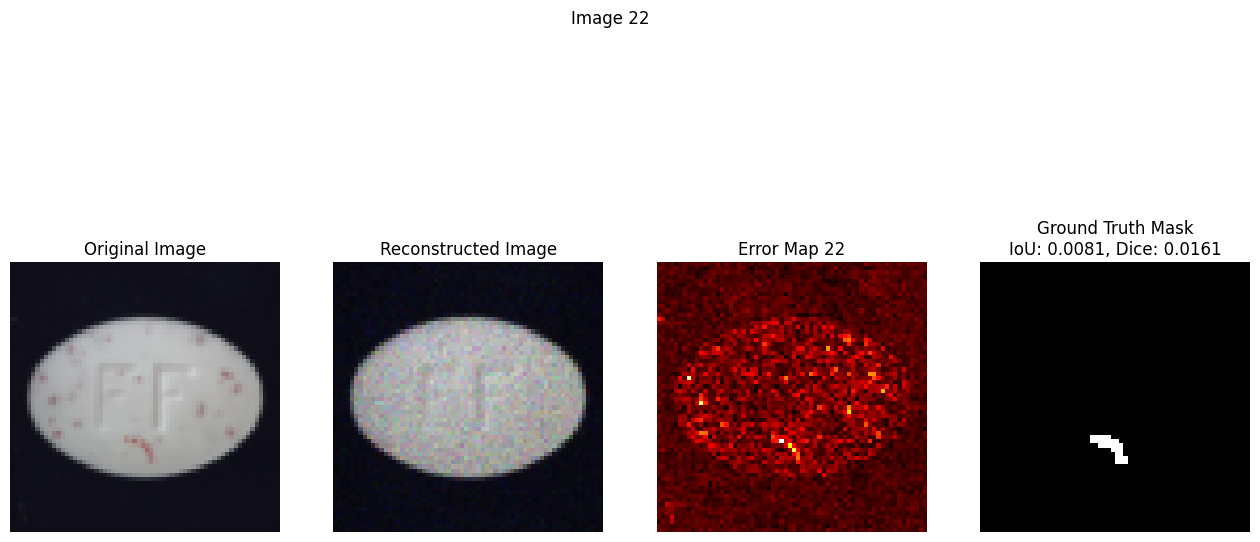

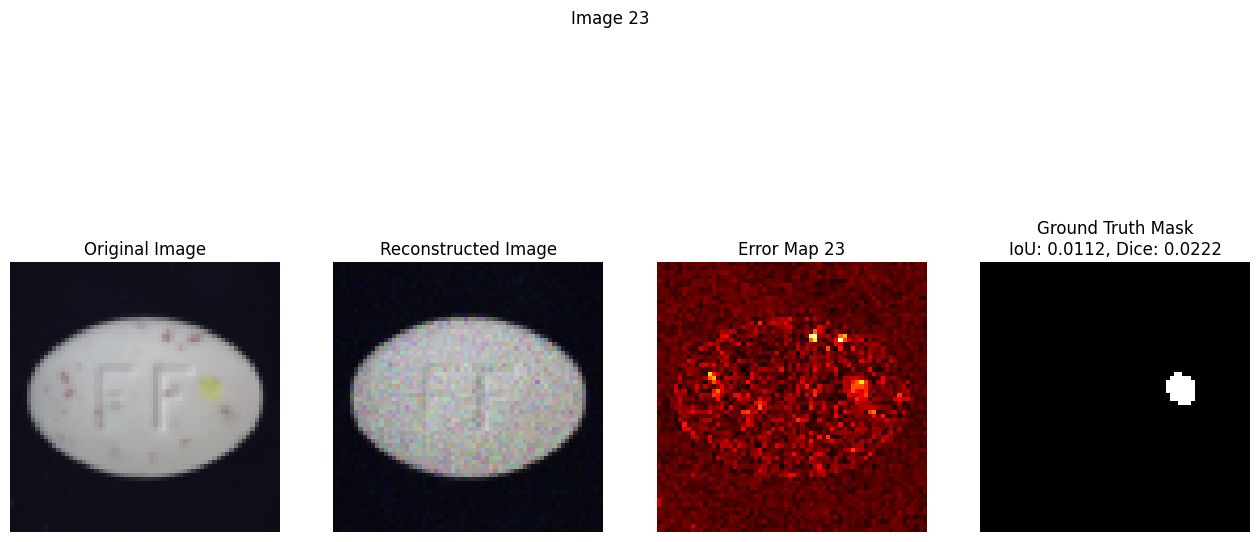

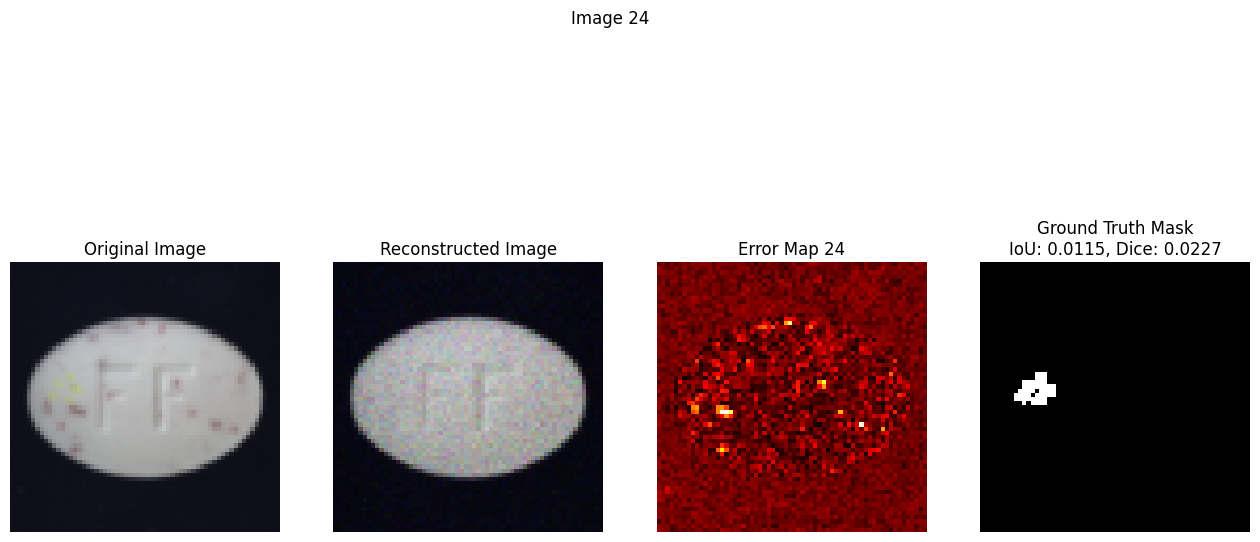

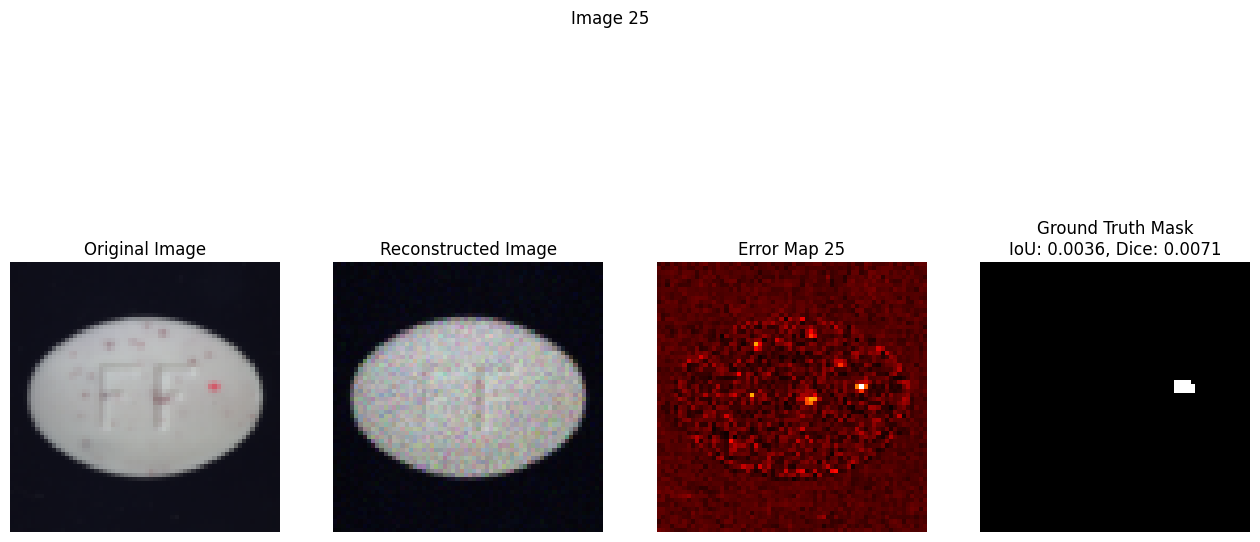

In [85]:
# Fonction pour dénormaliser une image
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # Annule la normalisation entre [-1, 1] pour revenir à [0, 1]

# Fonction pour calculer les métriques (IoU et Dice Score)
def calculate_metrics(predicted_mask, ground_truth_mask):
    predicted_mask_flat = predicted_mask.view(-1).cpu().numpy()
    ground_truth_mask_flat = ground_truth_mask.view(-1).cpu().numpy()
    
    # IoU (Intersection over Union)
    iou = jaccard_score(ground_truth_mask_flat, predicted_mask_flat)
    
    # Dice Score
    dice = f1_score(ground_truth_mask_flat, predicted_mask_flat)
    
    return iou, dice

# Fonction pour visualiser les résultats
def visualize_results(original, reconstructed, ground_truth_mask, idx, threshold=0.1):
    # Générer la carte d'erreur
    error_map = torch.abs(original - reconstructed).sum(dim=0) > threshold  # Threshold pour détecter les anomalies
    
    # Calculer les métriques
    iou, dice = calculate_metrics(error_map, ground_truth_mask)
    
    # Créer la visualisation
    plt.figure(figsize=(16, 8))
    
    # Image originale
    plt.subplot(1, 4, 1)
    plt.imshow(denormalize(original).permute(1, 2, 0).cpu().numpy())
    plt.title("Original Image")
    plt.axis("off")
    
    # Image reconstruite
    plt.subplot(1, 4, 2)
    plt.imshow(denormalize(reconstructed).permute(1, 2, 0).cpu().numpy())
    plt.title("Reconstructed Image")
    plt.axis("off")
    
    # Carte d'erreur

    diff = torch.abs(original - reconstructed).sum(dim=0).cpu().numpy()
    plt.subplot(1, 4, 3)
    plt.imshow(diff, cmap="hot")
    plt.title(f"Error Map {idx + 1}")
    plt.axis("off")
    
    # Masque de ground truth
    plt.subplot(1, 4, 4)
    plt.imshow(ground_truth_mask.cpu().numpy(), cmap="gray")
    plt.title(f"Ground Truth Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}")
    plt.axis("off")
    
    plt.suptitle(f"Image {idx + 1}")
    plt.show()

# Exemple d'utilisation
for idx, (original, reconstructed) in enumerate(zip(imgs, reconstructed_imgs)):
    mask_path = os.path.join(ground_truth_dir, mask_files[idx])  # Charger le masque correspondant
    ground_truth_mask = load_mask(mask_path, target_size=(64, 64))  # Charger et redimensionner le masque
    visualize_results(original, reconstructed, ground_truth_mask, idx)


In [98]:
# Fonction pour calculer les métriques globales
def calculate_classification_metrics(predicted_masks, ground_truth_masks):
    metrics = {"IoU": [], "Dice": [], "Precision": [], "Recall": [], "Accuracy": []}

    for predicted_mask, ground_truth_mask in zip(predicted_masks, ground_truth_masks):
        # Aplatir les masques pour les comparer pixel par pixel
        predicted_flat = predicted_mask.view(-1).cpu().numpy()
        ground_truth_flat = ground_truth_mask.view(-1).cpu().numpy()

        # Calculer les métriques
        iou = jaccard_score(ground_truth_flat, predicted_flat)
        dice = f1_score(ground_truth_flat, predicted_flat)
        precision = precision_score(ground_truth_flat, predicted_flat)
        recall = recall_score(ground_truth_flat, predicted_flat)
        accuracy = accuracy_score(ground_truth_flat, predicted_flat)

        # Ajouter les métriques au dictionnaire
        metrics["IoU"].append(iou)
        metrics["Dice"].append(dice)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["Accuracy"].append(accuracy)

    return metrics

# Initialisation des listes pour stocker les masques prédits et les masques de ground truth
predicted_masks = []
ground_truth_masks = []

# Générer les masques prédits et collecter les métriques
for idx, (original, reconstructed) in enumerate(zip(imgs, reconstructed_imgs)):
    mask_path = os.path.join(ground_truth_dir, mask_files[idx])
    ground_truth_mask = load_mask(mask_path, target_size=(64, 64))  # Charger et redimensionner le masque
    ground_truth_masks.append(ground_truth_mask)

    # Calculer la carte d'erreur
    error_map = torch.abs(original - reconstructed).sum(dim=0) > 0.5  # Threshold pour détecter l'anomalie
    predicted_masks.append(error_map)

# Calculer les métriques globales
metrics = calculate_classification_metrics(predicted_masks, ground_truth_masks)

# Générer un DataFrame pour afficher les résultats
results_df = pd.DataFrame({
    "Image": [f"Image {i+1}" for i in range(len(predicted_masks))],
    "IoU": metrics["IoU"],
    "Dice": metrics["Dice"],
    "Precision": metrics["Precision"],
    "Recall": metrics["Recall"],
    "Accuracy": metrics["Accuracy"]
})

# Afficher un résumé
print("=== Summary of Classification Metrics ===")
print(f"Mean IoU: {np.mean(metrics['IoU']):.4f}")
print(f"Mean Dice: {np.mean(metrics['Dice']):.4f}")
print(f"Mean Precision: {np.mean(metrics['Precision']):.4f}")
print(f"Mean Recall: {np.mean(metrics['Recall']):.4f}")
print(f"Mean Accuracy: {np.mean(metrics['Accuracy']):.4f}")

# Sauvegarder le rapport dans un fichier CSV
results_df.to_csv("classification_report.csv", index=False)
print("Classification report saved to 'classification_report.csv'.")


=== Summary of Classification Metrics ===
Mean IoU: 0.1063
Mean Dice: 0.1863
Mean Precision: 0.1421
Mean Recall: 0.3771
Mean Accuracy: 0.9807
Classification report saved to 'classification_report.csv'.
